# Projeto Forca

## Importações


In [7]:
import random
import requests
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Classe do jogo
A classe `JogoDeForca` gerencia o jogo de forca, com funções para iniciar o jogo, tentar adivinhar letras e a palavra, e controlar o número de vidas restantes.

In [8]:
class JogoDeForca:
    def __init__(self):
        url = 'https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt'
        r = requests.get(url, allow_redirects=True)
        if r.status_code == 200:
            self.content = str(r.content.decode()).split('\n')
        else:
            print("Erro: ", r.status_code)
    
    def novo_jogo(self, vidas=5):
        self.vidas = vidas
        self.palavra = random.choice(self.content).strip()
        return len(self.palavra)

    def tentar_letra(self, letra):
        if self.vidas > 0:
            if letra in self.palavra:
                return [idx for idx in range(len(self.palavra)) if self.palavra[idx] == letra]
            else:
                self.vidas -= 1
                return []
        return None
    
    def tentar_palavra(self, palavra):
        if self.vidas > 0:
            if self.palavra == palavra:
                return True
            else:
                self.vidas = 0
                return False
        return None


## Teste da classe do jogo
Os testes iniciam o jogo, mostram a palavra, tentam letras e exibem as vidas restantes.

In [9]:
jogo = JogoDeForca()
print(jogo.novo_jogo())
print("Palavra selecionada:", jogo.palavra)
print("Vidas iniciais:", jogo.vidas)
print("Tentativa de letra 'b':", jogo.tentar_letra('b'))
print("Tentativa de letra 'a':", jogo.tentar_letra('a'))
print("Tentativa de letra 'w':", jogo.tentar_letra('w'))
print("Vidas restantes após tentativas:", jogo.vidas)


11
Palavra selecionada: calejaramos
Vidas iniciais: 5
Tentativa de letra 'b': []
Tentativa de letra 'a': [1, 5, 7]
Tentativa de letra 'w': []
Vidas restantes após tentativas: 3


## Classe Jogador Automatico
A classe `JogadorAutomatico` escolhe letras e tenta adivinhar palavras em um jogo de forca, utilizando entropia para determinar as letras mais informativas, atualizando as palavras possíveis com base nas tentativas.

In [10]:
class JogadorAutomatico:
    def __init__(self, vocabulario):
        self.vocabulario = vocabulario
        self.possiveis_palavras = []
        self.letras_testadas = set()
        self.letras_informativas = self.calcular_entropia_letras()

    def calcular_entropia_letras(self):
        contador_letras = Counter("".join(self.vocabulario))
        total_letras = sum(contador_letras.values())
        entropia_letras = {letra: -freq / total_letras * math.log2(freq / total_letras) 
                           for letra, freq in contador_letras.items()}
        return sorted(entropia_letras, key=entropia_letras.get, reverse=True)

    def nova_partida(self, tamanho_palavra):
        self.possiveis_palavras = [p for p in self.vocabulario if len(p) == tamanho_palavra]
        self.letras_testadas.clear()

    def escolher_letra(self):
        for letra in self.letras_informativas:
            if letra not in self.letras_testadas:
                self.letras_testadas.add(letra)
                return letra
        return None

    def atualizar_palavras_possiveis(self, letra, indices):
        if indices:
            self.possiveis_palavras = [
                p for p in self.possiveis_palavras 
                if all(p[idx] == letra for idx in indices)
            ]
        else:
            self.possiveis_palavras = [p for p in self.possiveis_palavras if letra not in p]

    def tentar_palavra(self):
        if len(self.possiveis_palavras) == 1:
            return self.possiveis_palavras[0]
        return None


## Simular o jogo com o jogador automático

In [16]:
def simular_jogo(jogo, jogador):
    tamanho_palavra = jogo.novo_jogo()
    jogador.nova_partida(tamanho_palavra)
    #print("Nova palavra com", tamanho_palavra, "letras")

    while jogo.vidas > 0:
        palavra_tentativa = jogador.tentar_palavra()
        if palavra_tentativa:
            #print("Tentando palavra:", palavra_tentativa)
            if jogo.tentar_palavra(palavra_tentativa):
                #print("Ganhou!")
                return True
            else:
                #print("Perdeu!")
                return False

        letra = jogador.escolher_letra()
        if not letra:
            break
        #print("Tentando letra:", letra)
        indices = jogo.tentar_letra(letra)
        jogador.atualizar_palavras_possiveis(letra, indices)
        #print("Vidas restantes:", jogo.vidas)
    
    #print("Fim de jogo. A palavra era:", jogo.palavra)
    return False


## Executando a simulação
Utilizando do simulador para calcular a quantidade de acertos e erros

In [17]:
jogo = JogoDeForca()
jogador = JogadorAutomatico(jogo.content)
vitorias = 0
simulacoes = 100

for _ in range(simulacoes):
    if simular_jogo(jogo, jogador):
        vitorias += 1

print(f"Vitórias: {vitorias}/{simulacoes} - Taxa de sucesso: {vitorias / simulacoes * 100:.2f}%")

# Resultados das simulações
erros = simulacoes - vitorias
taxa_acerto = vitorias / simulacoes * 100
taxa_erro = erros / simulacoes * 100


Vitórias: 70/100 - Taxa de sucesso: 70.00%


## Plotando o primeiro gráfico (acertos por erro)

O gráfico de barras mostra a quantidade de acertos e erros em jogos simulados. A barra verde representa os jogos vencidos (acertos), enquanto a barra vermelha representa os jogos perdidos (erros). Ele visualiza o desempenho do jogador automático ao longo das simulações.

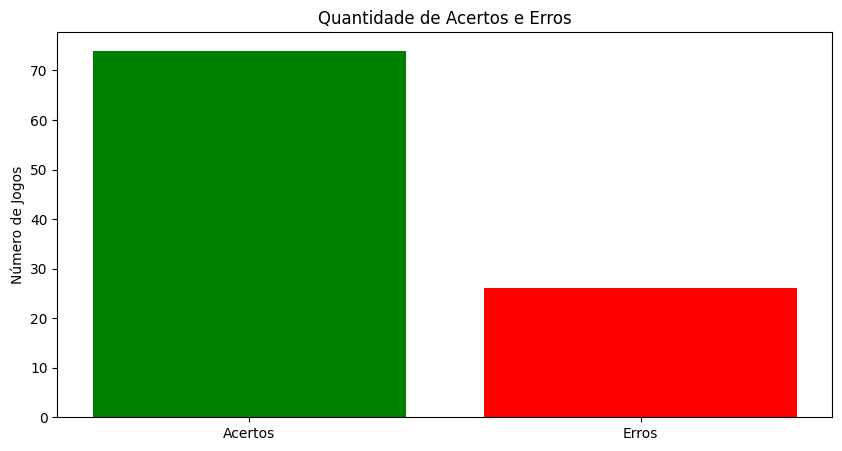

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(['Acertos', 'Erros'], [vitorias, erros], color=['green', 'red'])
plt.title('Quantidade de Acertos e Erros')
plt.ylabel('Número de Jogos')
plt.show()


## Calculando a media, desvio padrão e parâmetros da distribuição normal

O código calcula a distribuição normal com base na taxa de acerto do jogador. A média é a taxa de acerto, e o desvio padrão é calculado para medir a variação. Com esses valores, gera-se uma curva normal que mostra como os acertos estão distribuídos em torno da média.

In [14]:
media = taxa_acerto
desvio_padrao = math.sqrt((taxa_acerto * taxa_erro) / simulacoes)
x = np.linspace(media - 3*desvio_padrao, media + 3*desvio_padrao, 100)
y = norm.pdf(x, media, desvio_padrao)

## Plotando o gráfico de distribuição normal
O gráfico exibe a distribuição normal das taxas de acerto e erro, com linhas verticais marcando essas taxas e a área sob a curva representando a densidade de probabilidade.

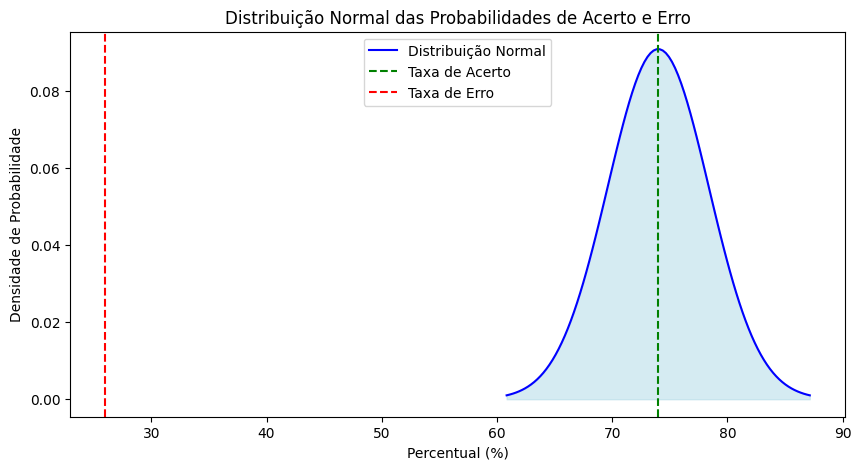

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='blue', label='Distribuição Normal')
plt.axvline(x=taxa_acerto, color='green', linestyle='--', label='Taxa de Acerto')
plt.axvline(x=taxa_erro, color='red', linestyle='--', label='Taxa de Erro')
plt.fill_between(x, y, color="lightblue", alpha=0.5)
plt.title('Distribuição Normal das Probabilidades de Acerto e Erro')
plt.xlabel('Percentual (%)')
plt.ylabel('Densidade de Probabilidade')
plt.legend()
plt.show()